In [1]:
%%capture
%pip install qldpc

In [2]:
import stim

from qldpc import circuits, codes
from qldpc.objects import Pauli

# Noise models in qLDPC

This notebook demonstrates how to use noise models in the `qLDPC` library.  Noise models are essential for simulating realistic quantum error correction scenarios by adding errors to quantum circuits.

We'll cover:
- Creating basic noise models with uniform depolarizing errors
- Applying noise to circuits with and without idling errors
- Working with quantum error correction codes
- Generating memory experiments with syndrome measurements

Let's start by exploring the basic functionality of noise models.

## Basic circuit creation

First, let's create a simple quantum circuit using Stim.  This example shows how to build a basic circuit with Hadamard and CNOT gates.

Original Circuit:


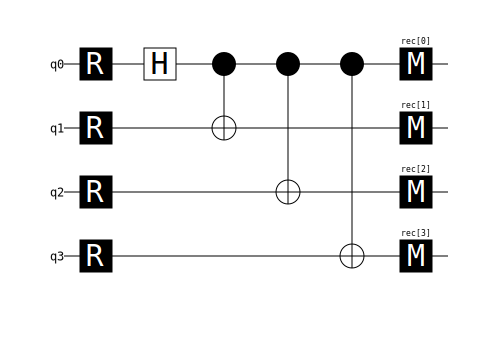

In [3]:
# Create a stim circuit:
# - reset four qubits to |0>
# - prepare the GHZ state |0000> + |1111>
# - measure all four qubits in the {|0>, |1>} basis
circuit = stim.Circuit()
circuit.append("RZ", [0, 1, 2, 3])
circuit.append("H", [0])
for q in range(1, 4):
    circuit.append("CNOT", [0, q])
circuit.append("M", [0, 1, 2, 3])

print("Original Circuit:")
circuit.diagram("timeline-svg")

## Applying noise models

Now we'll apply a uniform depolarizing noise model to our circuit.  Depolarizing noise is a common quantum error model where each qubit operation has a probability `p` of being followed by a random Pauli error (X, Y, or Z).  Reset gates have a probability `p` of resetting to the wrong state, and measurement gates have probability `p` of reporting the wrong outcome.

The parameter `include_idling_error=False` means we don't add errors during idle times, when qubits are not being actively operated on.

Noisy Circuit (no idling):


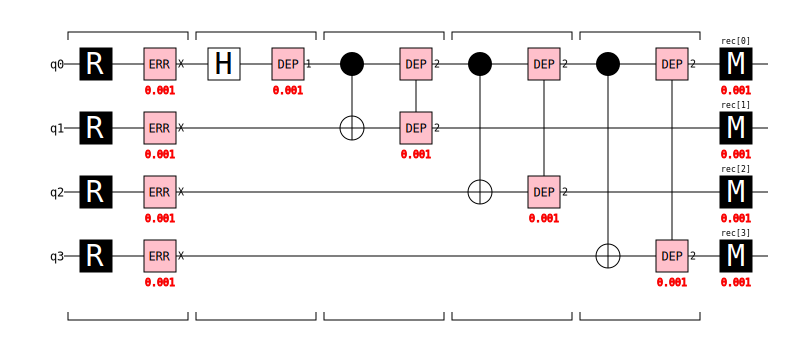

In [4]:
# Define a noise model
p = 0.001  # Error probability parameter
noise_model = circuits.DepolarizingNoiseModel(p, include_idling_error=False)

# Apply noise to your circuit
noisy_circuit = noise_model.noisy_circuit(circuit)

print("Noisy Circuit (no idling):")
noisy_circuit.diagram("timeline-svg")

## Including idling errors

In realistic quantum systems, qubits can experience errors even when they're not being actively operated on (during "idle" time).  Setting `include_idling_error=True` includes these errors in our noise model, making the simulation more realistic but also more complex.

Noisy Circuit (with idling):


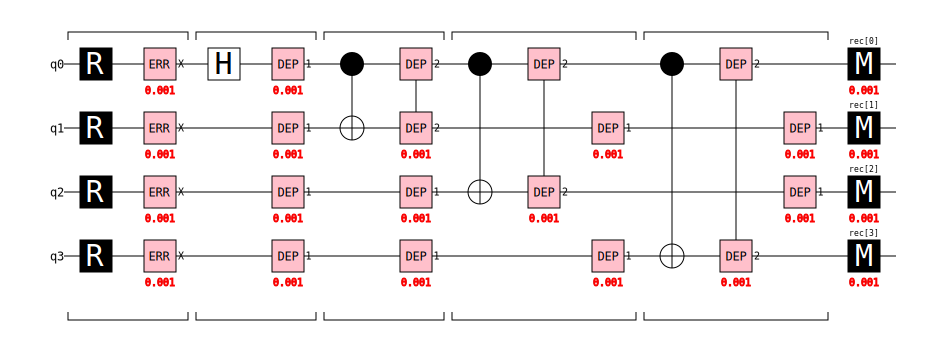

In [5]:
noise_model_with_idling = circuits.DepolarizingNoiseModel(p, include_idling_error=True)
noisy_circuit_with_idling = noise_model_with_idling.noisy_circuit(circuit)
print("Noisy Circuit (with idling):")
noisy_circuit_with_idling.diagram("timeline-svg")

Custom noise models allow more fine-grained more control over the error model.  See `help(qldpc.circuits.NoiseModel)` for additional details.

In the example below, we set different error rates one-qubit gates, two-qubit gates, measure (readout) and reset operations, and idling.

Noisy Circuit (custom noise model):


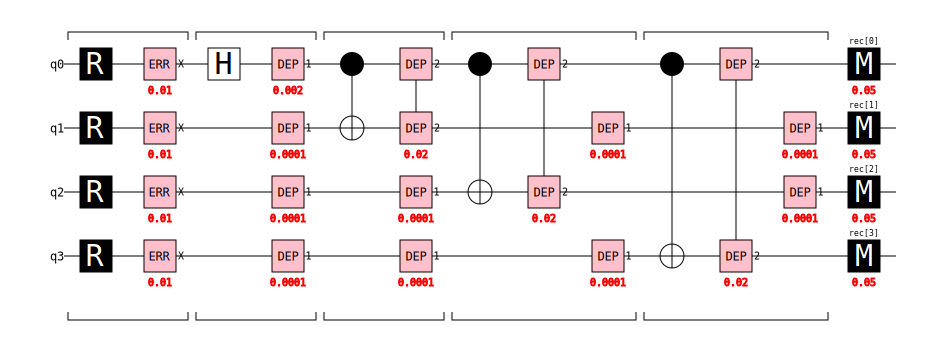

In [6]:
noise_model_with_idling = circuits.NoiseModel(
    clifford_1q_error=0.002,
    clifford_2q_error=0.02,
    readout_error=0.05,
    reset_error=0.01,
    idle_error=0.0001,
)

# Apply the custom noise model to the circuit
noisy_circuit_custom = noise_model_with_idling.noisy_circuit(circuit)
print("Noisy Circuit (custom noise model):")
noisy_circuit_custom.diagram("timeline-svg")

## Parallel operations and automatic TICK management

This example demonstrates how the noise model handles parallel two-qubit gates.  When qubits are reused in subsequent operations, TICK instructions are automatically added to properly sequence the operations and apply noise at appropriate intervals.

Noisy Circuit (no idling, new circuit):


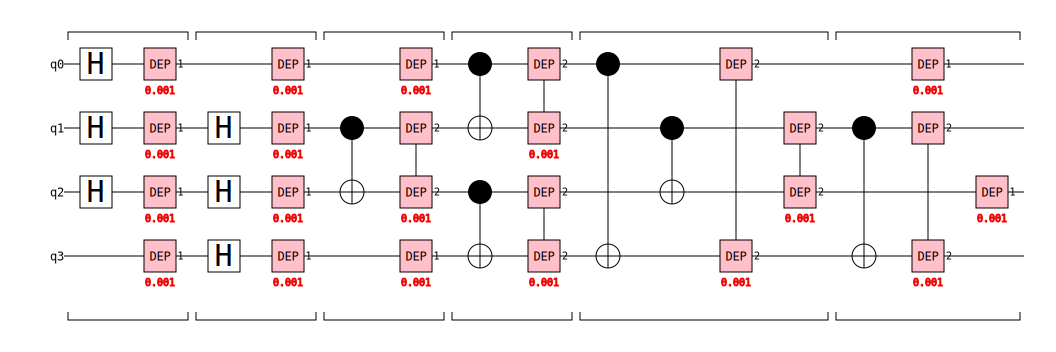

In [7]:
# example with parallel two qubit gates, TICKS will automatically be added before each qubit is reused

circuit = stim.Circuit()
circuit.append("H", [0, 1, 2])
circuit.append("H", [1, 2, 3])
circuit.append("CNOT", [1, 2, 0, 1, 2, 3, 0, 3, 1, 2, 1, 3])

noise_model = circuits.DepolarizingNoiseModel(p, include_idling_error=True)
noisy_circuit = noise_model.noisy_circuit(circuit)
print("Noisy Circuit (no idling, new circuit):")
noisy_circuit.diagram("timeline-svg")

We can also use TICKS to manually control the timing for idling errors.

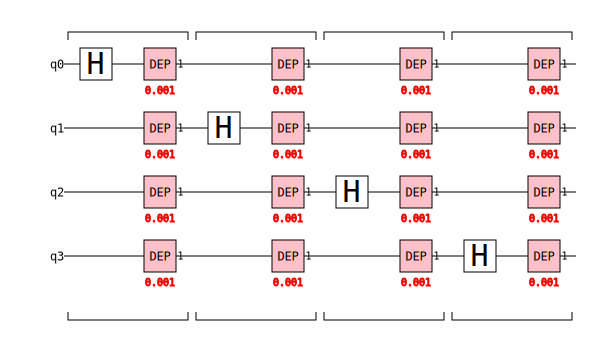

In [8]:
circuit = stim.Circuit()
for q in range(4):
    circuit.append("H", q)
    circuit.append("TICK")

noise_model.noisy_circuit(circuit, insert_ticks=False).diagram("timeline-svg")

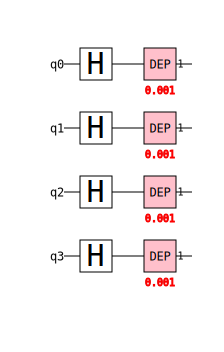

In [9]:
# compare to using automatic TICKS, in which case all H gates will be run in parallel
circuit = stim.Circuit()
for q in range(4):
    circuit.append("H", q)

noise_model.noisy_circuit(circuit).diagram("timeline-svg")

## Working with quantum error-correcting codes

Now let's move to more sophisticated examples using the syndrome extraction circuit for the Steane code.

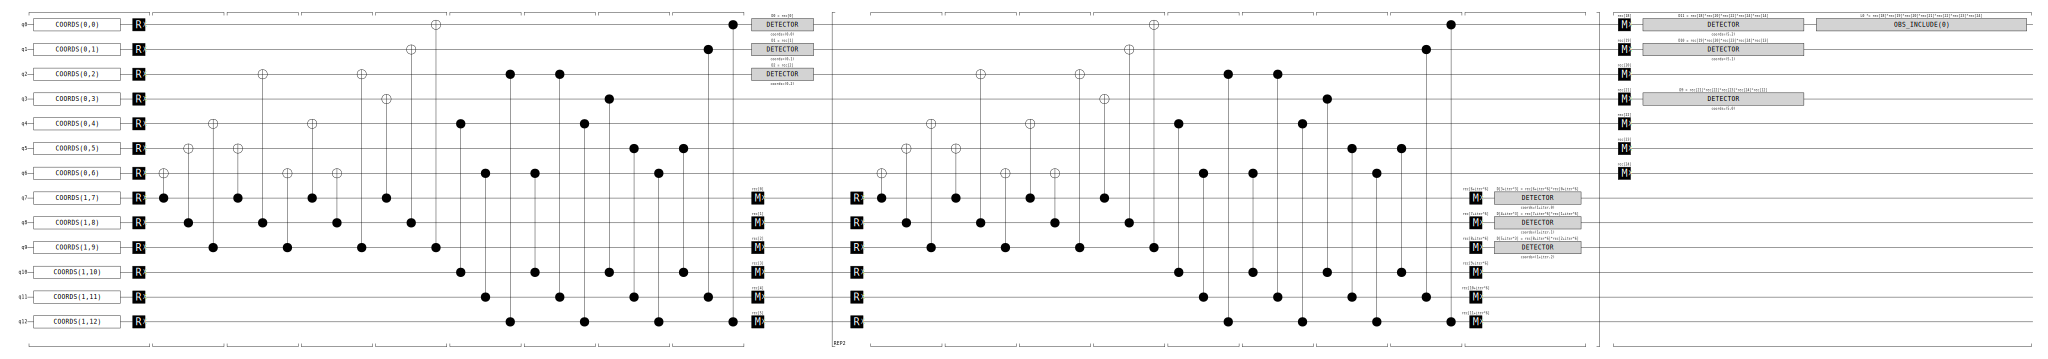

In [10]:
code = codes.SteaneCode()
circuit = circuits.get_memory_experiment(code, num_rounds=3)
circuit.diagram("timeline-svg")

Here we add noise to the syndrome measurement circuit.

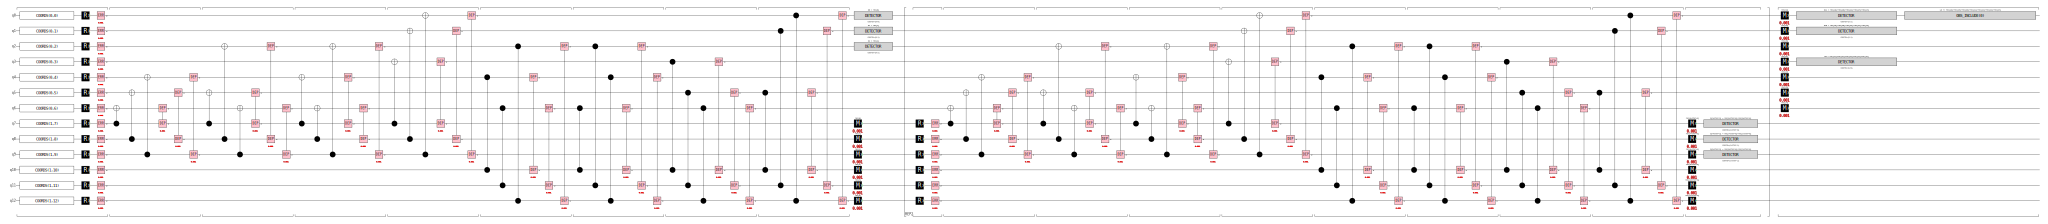

In [11]:
noise_model = circuits.DepolarizingNoiseModel(0.001, include_idling_error=False)
noisy_circuit = noise_model.noisy_circuit(circuit)
noisy_circuit.diagram("timeline-svg")

## Memory experiments with the surface code

Now we'll create a more comprehensive example using a surface code, which is a promising candidate for scalable fault-tolerant quantum computation.  We'll simulate a "memory experiment" in which we:

1. Prepare a logical state
2. Perform multiple rounds of error correction
3. Measure the final logical state

This simulates how well the code preserves quantum information over time in the presence of noise.

Code parameters: (9, 1, 3)


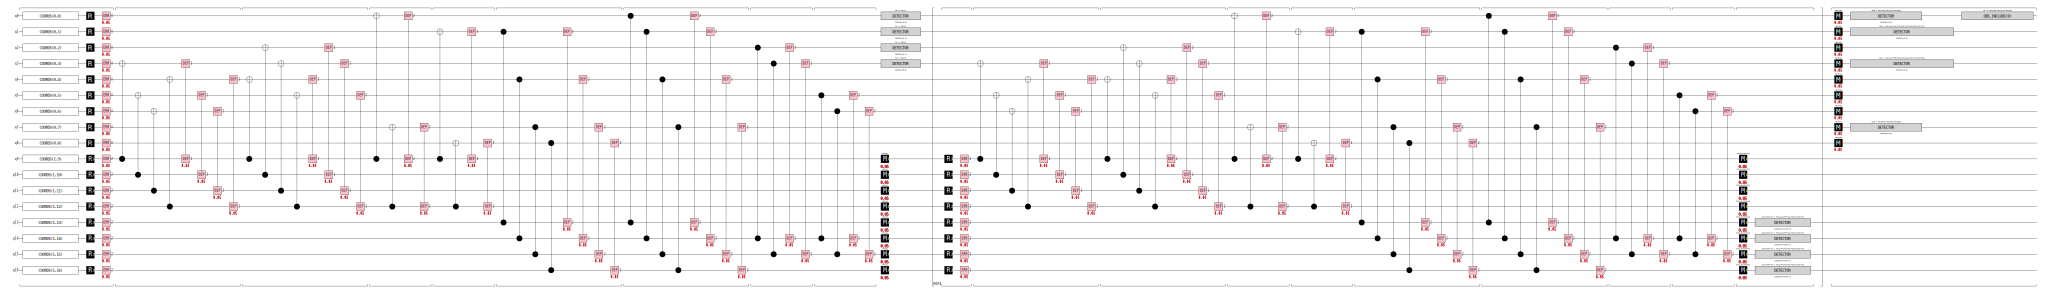

In [12]:
# Create a 3x3 surface code
code = codes.SurfaceCode(3)
print("Code parameters:", code.get_code_params())

# Generate noisy 5-round memory experiment for the logical Z operator
num_rounds = 5
basis = Pauli.Z
noise_model = circuits.DepolarizingNoiseModel(0.05, include_idling_error=False)
noisy_circuit = circuits.get_memory_experiment(
    code=code,
    num_rounds=num_rounds,
    basis=basis,
    noise_model=noise_model,
)

noisy_circuit.diagram("timeline-svg")

### Sampling syndrome measurements

We can sample measurement outcomes from our noisy memory experiment.  Each row represents the measurements from one round of error correction, showing which stabilizer checks detected errors.  The pattern of syndromes over time can be used to infer what errors occurred and how to correct them.

In [13]:
measurement_sampler = noisy_circuit.compile_sampler()
measurements = measurement_sampler.sample(shots=1)[
    0
]  # sample measurement outcomes for one circuit run

# extract X-type syndromes (that diagnose Z errors) and Z-type syndromes (that diagnose X errors)
syndromes = measurements[
    : -len(code)
]  # strip off the final qubit measurements, so that we are only left with syndrome measurements
syndromes = syndromes.reshape(num_rounds, 2, code.num_checks // 2)
syndromes_x = syndromes[:, 0, :]
syndromes_z = syndromes[:, 1, :]


def to_bitmask(timeslice):
    return "".join("1" if e else "_" for e in timeslice)


# print Z-type syndromes, which diagnoze X-type errors, which corrupt the logical Z operator
for syndrome in syndromes_z:
    print(to_bitmask(syndrome))

_1__
_1__
__1_
111_
11__


### Detector sampling

Finally, we can use Stim's detector sampling feature, which provides a powerful tool for analyzing circuit errors.  Detectors identify when syndromes *change* between rounds, which is often easier to decode on a circuit level than the raw syndromes themselves.

In [14]:
detector_sampler = noisy_circuit.compile_detector_sampler()
detectors = detector_sampler.sample(shots=1)[0]  # sample detector outcomes for one circuit run

# A Z-basis memory experiment only includes detectors for Z-type syndromes.
# Organize these detectors by measurement round, plus detectors for syndromes from the final data qubit measurements.
detectors = detectors.reshape(num_rounds + 1, code.num_checks_z)

for flips in detectors:
    print(to_bitmask(flips))

1__1
1___
1___
1___
__1_
__1_


For full quantum memory experiments with Sinter, see [logical_error_rates.ipynb](logical_error_rates.ipynb).